In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src import *

In [4]:
def calculate_errors(model, config):
    dists_to_center = []
    abs_errors = []

    for file in config.testing_files:
        video = Video(file, config)
        from_time, till_time = video.get_from_till_time(Part.WHOLE)
        probs = validate_video(video, model, return_preds=False, from_time=from_time, till_time=till_time, classification=True)
        preds, n_predicted = inference(probs, config)
        labels = get_labels(video, from_time, till_time)

        mask = labels['n_counts'] != 0

        dist_to_center = labels['dist_to_center'][mask]
        n_counts = labels['n_counts'][mask]
        preds = preds['n_counts'][mask]
        
        abs_error = np.abs(preds - n_counts)

        dists_to_center.extend(dist_to_center)
        abs_errors.extend(abs_error)

    dists_to_center = np.array(dists_to_center)
    abs_errors = np.array(abs_errors)

    return dists_to_center, abs_errors


def plot_errors(dists_to_center, abs_errors):
    mean_abs_errors = []

    N = 30
    X = np.linspace(0, 3, N)
    for i, j in zip(range(0, N - 1), range(1, N)):
        mask = (X[i] <= dists_to_center) & (X[j] > dists_to_center)
        mean_abs_error = abs_errors[mask].mean()
        mean_abs_errors.append(mean_abs_error)

    plt.plot(X[range(0, N - 1)], mean_abs_errors)

    return mean_abs_errors

### Example

[0.13953488372093023,
 0.14634146341463414,
 0.21568627450980393,
 0.21052631578947367,
 0.06976744186046512,
 0.26785714285714285,
 0.21739130434782608,
 0.14814814814814814,
 0.13043478260869565,
 0.15789473684210525,
 0.23529411764705882,
 0.12195121951219512,
 0.17391304347826086,
 0.24,
 0.1791044776119403,
 0.28,
 0.25,
 0.2,
 0.2549019607843137,
 0.22950819672131148,
 0.20270270270270271,
 0.22727272727272727,
 0.11764705882352941,
 0.2692307692307692,
 0.1864406779661017,
 0.27450980392156865,
 0.42105263157894735,
 0.5094339622641509,
 0.6666666666666666]

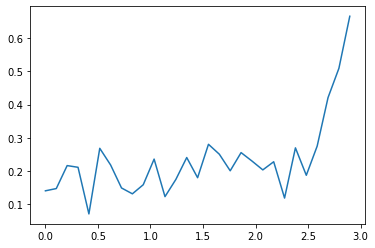

In [4]:
uuid = '010_eyedea_all_aligned_RX100/0'
model, config = load_model_locally(uuid, model_name='rvce')
dists_to_center, abs_errors = calculate_errors(model, config)
plot_errors(dists_to_center, abs_errors)

### Validate all

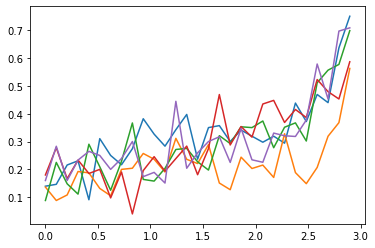

In [5]:
mean_abs_errors_folds = []
for i in range(5):
    uuid = f'010_eyedea_all_aligned_RX100/{i}'
    model, config = load_model_locally(uuid, model_name='rvce')
    dists_to_center, abs_errors = calculate_errors(model, config)
    mean_abs_errors = plot_errors(dists_to_center, abs_errors)
    mean_abs_errors_folds.append(mean_abs_errors)

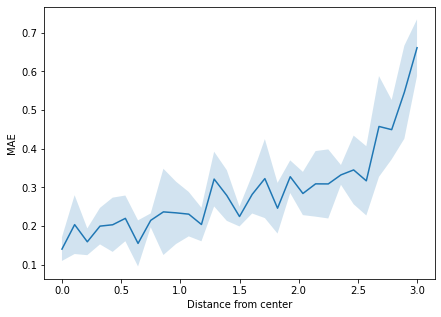

In [7]:
N = 30
X = np.linspace(0, 3, N - 1)
means = np.mean(mean_abs_errors_folds, axis=0)
stds = np.std(mean_abs_errors_folds, axis=0)

plt.figure(figsize=(7, 5))
plt.ylabel('MAE')
plt.xlabel('Distance from center')
plt.plot(X, np.mean(mean_abs_errors_folds, axis=0))
plt.fill_between(X, means - stds, means + stds, alpha=0.2)